In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec

import scanpy as sc

In [1]:
import sys
sys.path.append('../../')

In [2]:
font_size = 5
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':0.5,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size, 'legend.fontsize':font_size, 
    'legend.loc': 'center right',
    'legend.borderpad':0,
    'legend.columnspacing': 0.5,
    'legend.labelspacing': 0.2,
    'legend.handletextpad': 0,
    'legend.borderaxespad': 0,
    'legend.handleheight': 0.5,
    'legend.handlelength': 1.0,
}

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches

In [3]:
adata = sc.read_h5ad('./result/cci/MB/adata_mouse_brain.h5ad')
adata

AnnData object with n_obs × n_vars = 5150 × 24038
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'SpaSEG_discrete_clusters', 'SpaSEG_clusters', 'spot_neighbors'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'SpaSEG_clusters_colors', 'domain_lr_means', 'metrics', 'pca', 'spatial_neighbors'
    obsm: 'X_pca', 'cell_types', 'spatial', 'spot_lr_padj', 'spot_lr_score'
    varm: 'PCs'
    layers: 'count'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [4]:
_raw_adata_df = adata.to_df().copy()
sc.pp.scale(adata)

In [5]:
L_to_view = ['Vegfa', 'Vegfd', 
             'Sema3c', 'Sema3a', 'Sema3e',   #'Sema3f','Il16',
             'Col24a1', 'Col17a1',
             'Pdgfc',
#              'Dlk1',
             'Angpt1',
             'Bdnf', 'Efna3', 'Efnb3',
             'Nrg1']#'Col12a1',
R_to_view = ['Kdr', 'Flt1', 'Nrp2', 'Nrp1',      #'Flt4', 'Ephb2',
             'Plxna1', 'Plxnd1',       #'Plxna3'
             'Itga1',
             'Pdgfra',
#              'Notch1',
             'Tek',
             # 'Grin2c', 'Grin2d',
             'Ntrk2', 'Epha4', 'Ephb1',
             'Erbb4']

In [6]:
CT_to_view =['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1', 'Astro_HPC', 
            'Ext_L23', 'Ext_L25', 'Ext_L56', 'Ext_L5_1', 'Ext_L5_2', 'Ext_L5_3', 'Ext_L6B',
            'Astro_AMY_CTX',    #'Unk_1', 
            'Ext_Thal_1', 'Ext_Thal_2']

In [7]:
max_CT = pd.read_csv('./result/cci/MB/Mouse_brain_max_celltype_score.csv', index_col=0)
adata.obs['max_CT'] = max_CT

# L expression dotplot

In [8]:
# Get spot indices for each cell type
spot_indices = {}
for ct in adata.obsm['cell_types'].columns:
    spot_indices[ct] = max_CT[adata.obs['max_CT'] == ct].index

In [9]:
# Calculate expression and percentage for each cell type and each gene
CT_L_expre = {}
percentage_L_expre = {}
for ct in CT_to_view:
    spot_index_CT = spot_indices[ct]
    i_spot_L_expr = adata.to_df().loc[spot_index_CT, L_to_view]
    i_spot_L_expr_raw = _raw_adata_df.loc[spot_index_CT, L_to_view]
    
    i_CT_L_exp = i_spot_L_expr.mean()
    i_CT_L_exp.name = ct
    CT_L_expre[ct] = i_CT_L_exp
    
    i_CT_L_pct = (i_spot_L_expr_raw[L_to_view] > 0).mean()
    i_CT_L_pct.name = ct
    percentage_L_expre[ct] = i_CT_L_pct
    
CT_L_expre = pd.DataFrame(CT_L_expre)
CT_L_expre = CT_L_expre.dropna(axis=1).T.reset_index().rename(columns={'index':'celltype'})

percentage_L_expre = pd.DataFrame(percentage_L_expre)
percentage_L_expre[percentage_L_expre<0.25]=0
percentage_L_expre = percentage_L_expre.dropna(axis=1).T.reset_index().rename(columns={'index':'celltype'})

genes_ = CT_L_expre.columns[1:].tolist()

In [10]:
celltype_arr = []
gene_arr = []
mean_exp_arr = []
fraction_arr = []

for index, row in CT_L_expre.iterrows():
    _ct = row['celltype']
    for i_gene in genes_:
        celltype_arr.append(_ct)
        gene_arr.append(i_gene)
        mean_exp_arr.append(row[i_gene])
        fraction_arr.append(
            percentage_L_expre.loc[percentage_L_expre['celltype']==_ct, i_gene].values[0]
        )
_mean_gene_frac_df = pd.DataFrame({'celltype': celltype_arr, 'gene':gene_arr, 'mean_exp':mean_exp_arr, 'frac':fraction_arr})

In [11]:
import matplotlib.transforms as mtransforms
clist=[
'#B3C9D7',
'#F87455',
'#FE1B0A',
]
newcmp = LinearSegmentedColormap.from_list('new',clist)

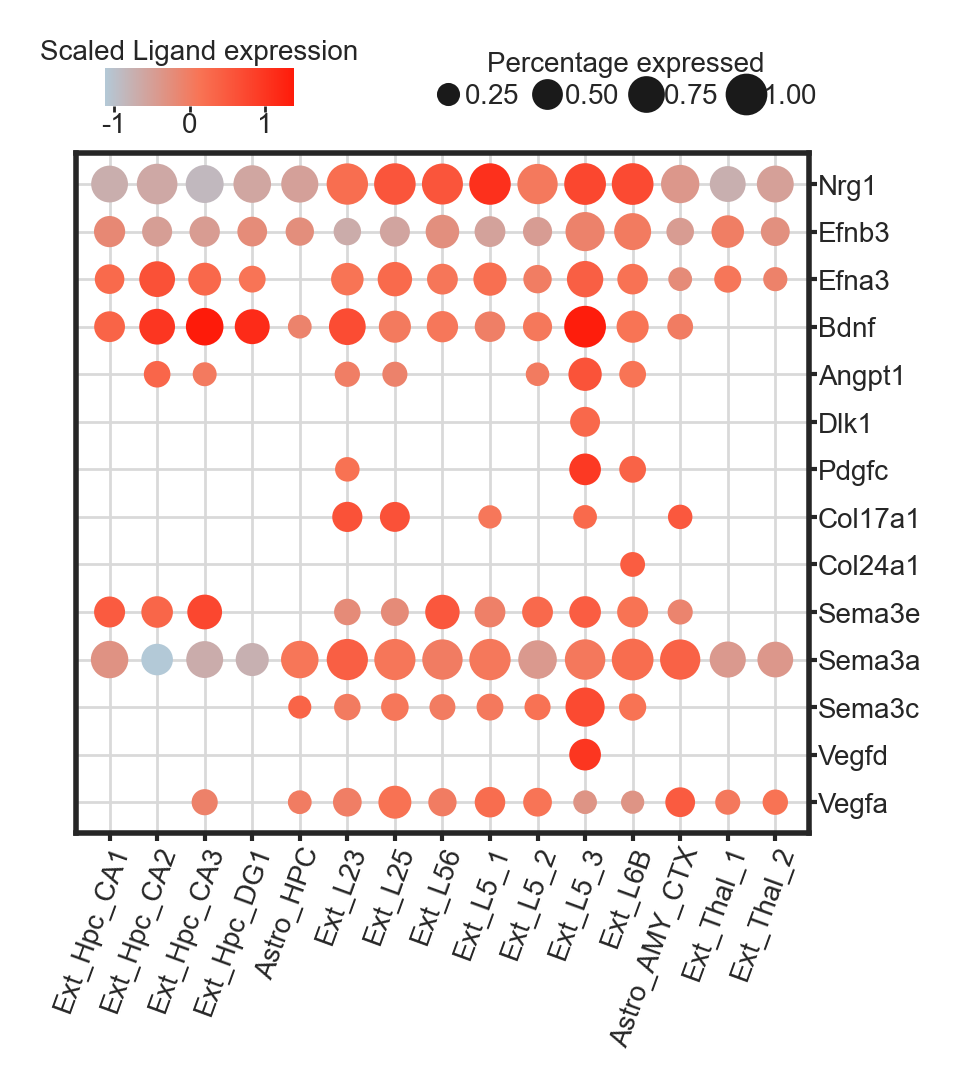

In [12]:
fig = plt.figure(figsize=(6*centimeter, 6*centimeter), dpi=400)
ax = plt.subplot(aspect = 'equal')
scatter_L = ax.scatter(
    x = _mean_gene_frac_df['celltype'],
    y = _mean_gene_frac_df['gene'],
    c = _mean_gene_frac_df['mean_exp'],
#     c = np.log(x_y_scatter['expression'].values),
    s = _mean_gene_frac_df['frac']*45,
    cmap = newcmp,
)
plt.xticks(rotation=70, fontsize=5, ha='right', rotation_mode="anchor")
plt.yticks(fontsize=5, )
ax.tick_params(direction='out', labelsize=5, length=1.5, width=0.75, 
               top=False, right=True, left=False, pad=0.2,
               grid_alpha=1, labelright=True, labelleft=False)

# colorbar cax
cax = ax.figure.add_axes(mtransforms.Bbox.from_extents(ax.get_position().x0+0.03,
                              ax.get_position().y1 + 0.05,
                              ax.get_position().x0 +0.03 + 0.2,
                              ax.get_position().y1 + 0.05 + 0.04), )   # facecolor='none'
cbar = plt.colorbar(scatter_L, cax=cax, orientation='horizontal')  # , ticks=[0, 0.4, 0.8]
cbar.ax.tick_params(direction='out',  which='both', labelsize=5, length=1, width=0.5, pad=0.2)
cax.set_title("Scaled Ligand expression", fontsize=5, pad=1.6)
cax.set_frame_on(False)


# legend
handles, labels = scatter_L.legend_elements(prop="sizes", num=4, func=lambda x: x/45)
legend2 = ax.legend(handles, labels, loc="upper center", bbox_to_anchor=[0.75, 1.15], 
                    title="Percentage expressed", title_fontsize=5,
                    fontsize=5, ncols=5, frameon=False, markerscale=1.0, 
                    handletextpad=0.1)
ax.grid(color='0.85', linewidth=0.5)

# plt.savefig('/media/bgi/liukeyin/SpaSEG/cci/Fig5/Fig5_scale_Ligand_expression.pdf', bbox_inches='tight', format='pdf', dpi=400)

# R expression dotplot

In [13]:
# Calculate expression and percentage for each cell type and each gene
CT_R_expre = {}
percentage_R_expre = {}
for ct in CT_to_view:
    spot_index_CT = spot_indices[ct]
    i_spot_R_expr = adata.to_df().loc[spot_index_CT, R_to_view]
    i_spot_R_expr_raw = _raw_adata_df.loc[spot_index_CT, R_to_view]
    
    i_CT_R_exp = i_spot_R_expr.mean()
    i_CT_R_exp.name = ct
    CT_R_expre[ct] = i_CT_R_exp
    
    i_CT_R_pct = (i_spot_R_expr_raw[R_to_view] > 0).mean()
    i_CT_R_pct.name = ct
    percentage_R_expre[ct] = i_CT_R_pct
    
CT_R_expre = pd.DataFrame(CT_R_expre)
CT_R_expre = CT_R_expre.dropna(axis=1).T.reset_index().rename(columns={'index':'celltype'})

percentage_R_expre = pd.DataFrame(percentage_R_expre)
percentage_R_expre[percentage_R_expre<0.25]=0
percentage_R_expre = percentage_R_expre.dropna(axis=1).T.reset_index().rename(columns={'index':'celltype'})

genes_ = CT_R_expre.columns[1:].tolist()

In [14]:
celltype_arr = []
gene_arr = []
mean_exp_arr = []
fraction_arr = []

for index, row in CT_R_expre.iterrows():
    _ct = row['celltype']
    for i_gene in genes_:
        celltype_arr.append(_ct)
        gene_arr.append(i_gene)
        mean_exp_arr.append(row[i_gene])
        fraction_arr.append(
            percentage_R_expre.loc[percentage_R_expre['celltype']==_ct, i_gene].values[0]
        )
_mean_gene_frac_df = pd.DataFrame({'celltype': celltype_arr, 'gene':gene_arr, 'mean_exp':mean_exp_arr, 'frac':fraction_arr})

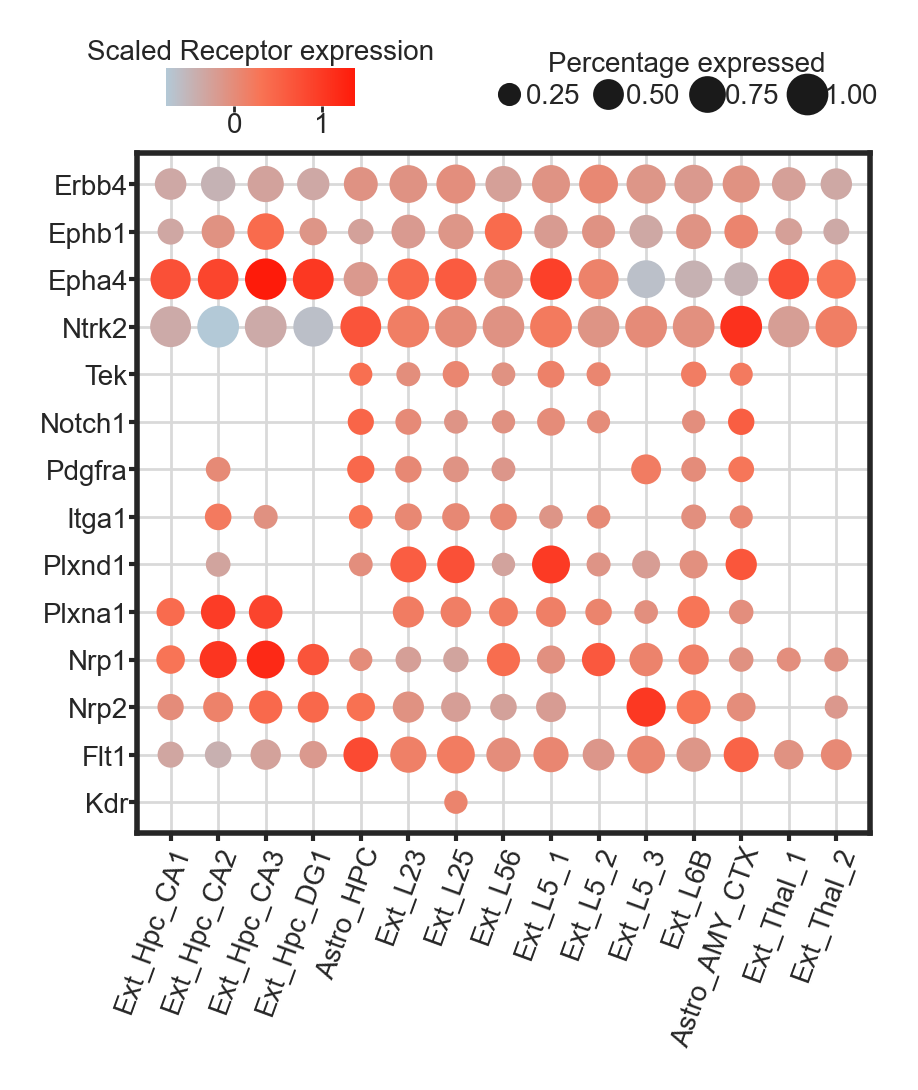

In [15]:
fig = plt.figure(figsize=(6*centimeter, 6*centimeter), dpi=400)
ax = plt.subplot(aspect = 'equal')
scatter_R = ax.scatter(
    x = _mean_gene_frac_df['celltype'],
    y = _mean_gene_frac_df['gene'],
    c = _mean_gene_frac_df['mean_exp'],
#     c = np.log(x_y_scatter['expression'].values),
    s = _mean_gene_frac_df['frac']*45,
    cmap = newcmp,  #rainbow   coolwarm
)
plt.xticks(rotation=70, fontsize=5, ha='right', rotation_mode="anchor")
plt.yticks(fontsize=5, )
ax.tick_params(direction='out', labelsize=5, length=1.5, width=0.75, 
               top=False, right=False, left=True, pad=0.2,
               grid_alpha=1, labelright=False, labelleft=True)

# colorbar cax
cax = ax.figure.add_axes(mtransforms.Bbox.from_extents(ax.get_position().x0+0.03,
                              ax.get_position().y1 + 0.05,
                              ax.get_position().x0 +0.03 + 0.2,
                              ax.get_position().y1 + 0.05 + 0.04), )   # facecolor='none'
cbar = plt.colorbar(scatter_R, cax=cax, orientation='horizontal')  # , ticks=[0, 0.4, 0.8]
cbar.ax.tick_params(direction='out',  which='both', labelsize=5, length=1, width=0.5, pad=0.2)
cax.set_title("Scaled Receptor expression", fontsize=5, pad=1.6)
cax.set_frame_on(False)


# legend
handles, labels = scatter_R.legend_elements(prop="sizes", num=4, func=lambda x: x/45)
legend2 = ax.legend(handles, labels, loc="upper center", bbox_to_anchor=[0.75, 1.15], 
                    title="Percentage expressed", title_fontsize=5,
                    fontsize=5, ncols=5, frameon=False, markerscale=1.0, 
                    handletextpad=0.1)
ax.grid(color='0.85', linewidth=0.5)

# plt.savefig('/media/bgi/liukeyin/SpaSEG/cci/Fig5/Fig5_scale_Receptor_expression.pdf', bbox_inches='tight', format='pdf', dpi=400)